In [2]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [ ]:
import imp
imp.reload(xy)

In [3]:
import xy

# $因子描述：TecIndex$

## 计算

In [7]:
sdt = '2016-01-04 15:00'
kr = 240

In [10]:
def cal_upshadow(index_ret, high, low, cl, op):
    upShadow = pd.Series(np.nan,index = index_ret.index)
    upShadow.loc[index_ret[index_ret>0].index] = (high - cl)
    upShadow.loc[index_ret[index_ret<=0].index] = (high - op)
    
    return upShadow

def cal_downshadow(index_ret, high, low, cl, op):
    downShadow = pd.Series(np.nan,index = index_ret.index)
    downShadow.loc[index_ret[index_ret>0].index] = (-low + op)
    downShadow.loc[index_ret[index_ret<=0].index] = (-low + cl)
    
    return downShadow

In [174]:
def cal_shadow_ratio(arr):
    ret1000_30min = arr.close[kr-1::kr].pct_change().dropna().loc[sdt:]
    open1000_30min = arr.open.rolling(kr).apply(lambda x:x[0])[kr-1::kr].loc[sdt:].dropna()
    close1000_30min = arr.close.rolling(kr).apply(lambda x:x[-1])[kr-1::kr].loc[sdt:].dropna()
    high1000_30min = arr.high.rolling(kr).max()[kr-1::kr].loc[sdt:].dropna()
    low1000_30min = arr.low.rolling(kr).min()[kr-1::kr].loc[sdt:].dropna()

    up = cal_upshadow(ret1000_30min, high1000_30min, low1000_30min, close1000_30min, open1000_30min).rename('up')
    # down = cal_downshadow(ret1000_30min, high1000_30min, low1000_30min, close1000_30min, open1000_30min).rename('down')

    shadow_ratio = (up-down)
    # shadow_ratio = shadow_ratio[(down>0) ]
    shadow_ratio.index = shadow_ratio.index.map(lambda x:x[:10])
    
    return shadow_ratio

In [175]:
sr1000 = cal_shadow_ratio(xy.IndexMin1000jq.dropna())
sr500 = cal_shadow_ratio(xy.IndexMin500jq.dropna())
sr300 = cal_shadow_ratio(xy.IndexMin300jq.dropna())
sr50 = cal_shadow_ratio(xy.IndexMin50jq.dropna())

In [240]:
idx_SR = pd.concat([
    sr50.rename('50'),
    sr300.rename('300'),
    sr500.rename('500'),
    sr1000.rename('1000'),
],axis=1).shift()

<Axes: >

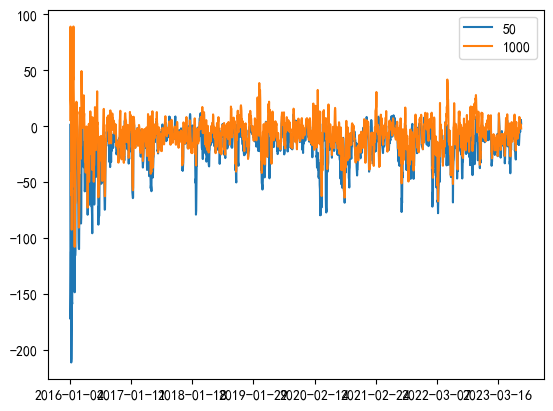

In [241]:
idx_SR[['50','1000']].rolling(5,min_periods=1).mean().plot()

In [242]:
# idx_SR['1000'] = idx_SR['1000'].map(lambda x:x**(1/3) if x>0 else (-x)**(1/3))
# idx_SR['500'] = idx_SR['500'].map(lambda x:x**(1/3) if x>0 else (-x)**(1/3))
# idx_SR['300'] = idx_SR['300'].map(lambda x:x**(1/3) if x>0 else (-x)**(1/3))
# idx_SR['50'] = idx_SR['50'].map(lambda x:x**(1/3) if x>0 else (-x)**(1/3))

In [254]:
xy.Index_rets.T.iloc[:,:4].shift()>0

,50,300,500,1000
2016-01-04,False,False,False,False
2016-01-05,False,False,False,False
2016-01-06,True,True,False,False
2016-01-07,True,True,True,True
2016-01-08,False,False,False,False
...,...,...,...,...
2023-08-22,False,False,False,False
2023-08-23,True,True,True,True
2023-08-24,False,False,False,False
2023-08-25,True,True,True,True


In [251]:
idx_SR

,50,300,500,1000
2016-01-04,NaN,NaN,NaN,NaN
2016-01-05,1.21,1.43,9.80,5.48
2016-01-06,-345.93,-327.80,-10.24,172.44
2016-01-07,-103.64,-103.22,-106.46,-106.37
2016-01-08,0.00,0.00,0.00,0.00
...,...,...,...,...
2023-07-31,-13.83,-11.88,-13.54,-13.76
2023-08-01,47.37,49.73,45.48,33.90
2023-08-02,-7.23,-2.72,-10.14,-16.41
2023-08-03,-4.97,2.03,2.50,-5.39


In [258]:
(idx_SR[(idx_SR>0)&(xy.Index_rets.T.iloc[:,:4].shift()<0)]).count()

50      283
300     337
500     420
1000    426
dtype: int64

In [279]:
(idx_SR[(idx_SR>0)&(xy.Index_rets.T.iloc[:,:4].shift()<0)]).rolling(1,min_periods=1).mean().dropna().T

,2016-01-05,2016-01-12,2016-01-14,2016-01-22,2016-02-15,2016-03-11,2016-04-08,2016-04-22,2016-05-09,2016-06-14,...,2023-03-03,2023-03-08,2023-03-13,2023-05-10,2023-05-12,2023-05-15,2023-05-24,2023-07-07,2023-07-21,2023-07-28
50,1.21,17.63,4.41,42.92,6.42,0.57,2.24,20.15,0.89,8.36,...,7.46,19.56,16.07,27.18,1.98,5.25,4.47,3.94,7.70,6.13
300,1.43,39.50,16.59,66.17,4.07,5.80,3.28,26.28,3.44,11.33,...,8.01,21.32,9.48,26.34,7.95,10.78,3.71,11.67,13.21,11.17
500,9.80,95.69,57.33,163.96,11.50,26.06,8.15,74.41,18.25,48.39,...,2.72,6.73,6.69,31.17,0.39,34.14,3.15,23.43,7.95,8.86
1000,5.48,104.78,81.51,241.88,25.87,51.35,16.68,102.76,30.55,80.01,...,12.63,1.62,7.45,8.00,14.89,20.90,9.24,37.52,10.03,7.39


In [282]:
(idx_SR[(idx_SR>0)&(xy.Index_rets.T.iloc[:,:4].shift()<0)]).rolling(1,min_periods=1).mean().dropna().T.shift(1,axis=1)

,2016-01-05,2016-01-12,2016-01-14,2016-01-22,2016-02-15,2016-03-11,2016-04-08,2016-04-22,2016-05-09,2016-06-14,...,2023-03-03,2023-03-08,2023-03-13,2023-05-10,2023-05-12,2023-05-15,2023-05-24,2023-07-07,2023-07-21,2023-07-28
50,NaN,1.21,17.63,4.41,42.92,6.42,0.57,2.24,20.15,0.89,...,6.65,7.46,19.56,16.07,27.18,1.98,5.25,4.47,3.94,7.70
300,NaN,1.43,39.50,16.59,66.17,4.07,5.80,3.28,26.28,3.44,...,8.53,8.01,21.32,9.48,26.34,7.95,10.78,3.71,11.67,13.21
500,NaN,9.80,95.69,57.33,163.96,11.50,26.06,8.15,74.41,18.25,...,12.41,2.72,6.73,6.69,31.17,0.39,34.14,3.15,23.43,7.95
1000,NaN,5.48,104.78,81.51,241.88,25.87,51.35,16.68,102.76,30.55,...,4.81,12.63,1.62,7.45,8.00,14.89,20.90,9.24,37.52,10.03


0.0012920123593757077
1 0.9634146341463414
2 0.9634146341463414
3 0.9634146341463414
4 0.9634146341463414


<Axes: >

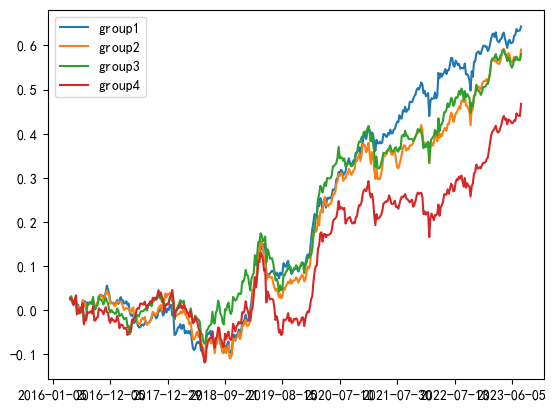

In [288]:
# 分组收益率
gr_SR = xy.cal_rate_group(
    (idx_SR[(idx_SR>0)&(xy.Index_rets.T.iloc[:,:4].shift()!=0)]).rolling(1,min_periods=1).mean().dropna().T.shift(15,axis=1).loc[:],
    xy.Index_rets.loc[:,'2016-01-04':],
    group_num=4,
    masks=1
)
gr_SR.cumsum().plot()

### 从股票计算（日频）

In [257]:
stCP_ovnday = xy.closes.T.apply(index_CP_daily,args=(1,))

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('Cannot apply_along_axis when any iteration dimensions are 0')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('Cannot apply_along_axis when any iteration dimensions are 0')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

ValueError('negative dimensions are not allowed')

In [266]:
stCP_ovnday.rolling(20).mean().T

,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,...,2023-08-14,2023-08-15,2023-08-16,2023-08-17,2023-08-18,2023-08-21,2023-08-22,2023-08-23,2023-08-24,2023-08-25
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.875,-6.375,-5.625,-4.525,-3.325,-2.250,-1.150,-0.125,0.925,1.825
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000008.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.875,-1.050,-0.175,0.775,1.750,2.750,3.725,4.300,4.650,5.325
688800.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.850,15.150,15.275,15.350,15.450,15.500,15.550,15.600,15.625,15.825
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.425,3.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688981.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000,1.600,1.400,1.175,0.950,0.925,0.950,0.975,1.025,1.025


In [275]:
F = (stCP_ovnday.rolling(20).std().T + stCP_ovnday.rolling(20).mean().T).loc[:,'2016-01-04':].shift(1,axis=1)

0.05030322182499126
1 149.4883215643672
2 149.96849538294404
3 149.88212927756655
4 149.97935904399782
5 150.09777294948398
6 149.7686040195546
7 149.89625203693646
8 149.9652362846279
9 149.88538837588268
10 150.376969038566


<Axes: >

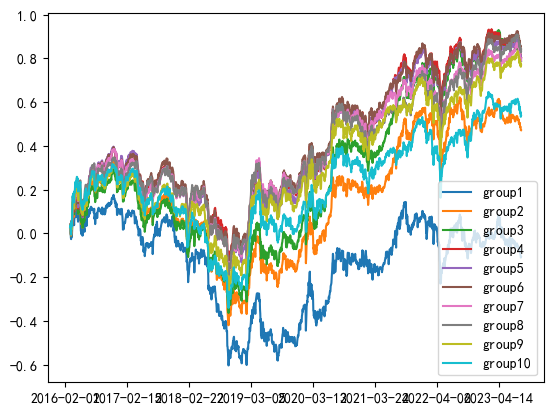

In [ ]:
# 分组收益率
gr_stCP_ovnday = xy.cal_rate_group(
    F.loc[F.index.isin(xy.weights1000.index)],
    xy.rets.loc[:,'2016-01-04':],
    group_num=10,
    masks=1
)
gr_stCP_ovnday.cumsum().plot()

In [297]:
idx_stCP_ovnday = xy.read_Factor(xy.trd_dates,'CP',df=F[(F.rank()<4000)&(F.rank()>1000)])#New_TSR1[(New_TSR1.rank()>4000)|(New_TSR1.rank()<1000)]

## 评估

### cl-cl

0.010964812748447312
1 0.9790209790209791
2 0.9790209790209791
3 0.9790209790209791
4 0.9790209790209791


<Axes: >

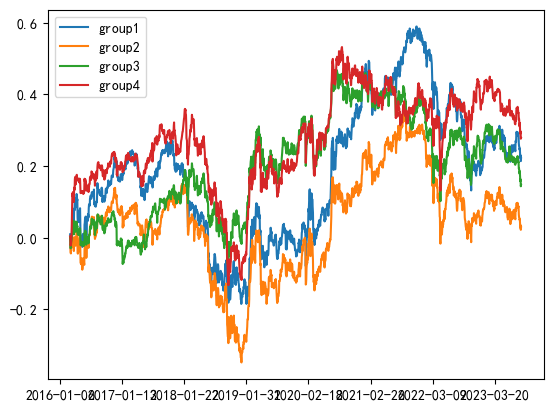

In [298]:
# 分组收益率
gr_kurs = xy.cal_rate_group(
    idx_stCP_ovnday.loc[:,'2016-01-06':],
    xy.Index_rets.loc[:,'2016-01-06':],
    group_num=4,
    masks=1
)
gr_kurs.cumsum().plot()

-0.05429772935557364
1 0.9972914409534128
2 0.9972914409534128
3 0.9972914409534128
4 0.9972914409534128


<Axes: >

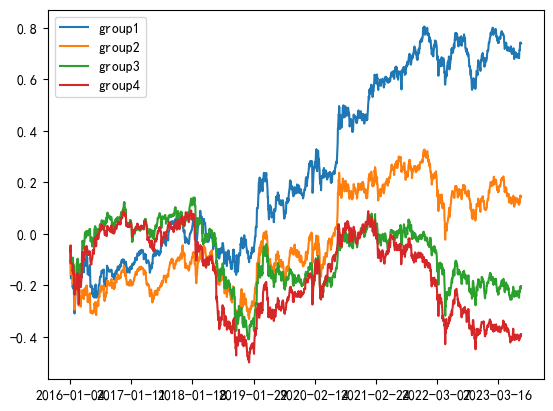

In [289]:
# 分组收益率
gr_kurs = xy.cal_rate_group(
    iCP_intraday.rolling(1).mean().T.loc[:,'2016-01-04':],
    xy.Index_rets.loc[:,'2016-01-04':],
    group_num=4,
    masks=1
)
gr_kurs.cumsum().plot()

In [219]:
(idx_SR**(1/3)).rolling(1,min_periods=1).mean().dropna().T.loc[:]

,2016-01-05,2016-01-08,2016-01-12,2016-01-14,2016-01-19,2016-01-22,2016-02-03,2016-02-05,2016-02-15,2016-02-16,...,2023-06-13,2023-06-15,2023-06-26,2023-06-28,2023-07-03,2023-07-07,2023-07-14,2023-07-21,2023-07-28,2023-08-01
50,1.065602,0.0,2.602660,1.639883,3.648570,3.501224,2.049593,2.076998,1.858568,3.366687,...,1.622343,1.830151,2.288156,1.803901,2.118655,1.579424,1.105209,1.974681,1.830151,3.618271
300,1.126623,0.0,3.405642,2.550442,3.157177,4.044707,2.209054,2.432881,1.596607,4.120107,...,1.249333,2.183485,2.226000,1.705404,2.219929,2.268247,1.380337,2.363928,2.235378,3.677388
500,2.139975,0.0,4.573923,3.855914,4.093824,5.473259,1.972970,2.818919,2.257179,3.067011,...,1.664308,2.268247,0.000000,1.882386,2.229359,2.861480,1.704257,1.995825,2.069242,3.569495
1000,1.763032,0.0,4.714397,4.335811,4.550863,6.230649,2.881692,3.170829,2.957550,3.489219,...,1.844958,1.713389,1.342575,2.168703,1.938991,3.347760,1.736909,2.156587,1.947817,3.236433


866.0
yoy: 0.311259432026554 
 mdd: -0.1782091089419684 
 sharpe: 1.5916077386122625 
 rankIC: -0.1324200913242009 
 rankIR: -0.13344399039004415 
 win%: 0.5530973451327433 
 gain_loss%: -1.0024701921320784


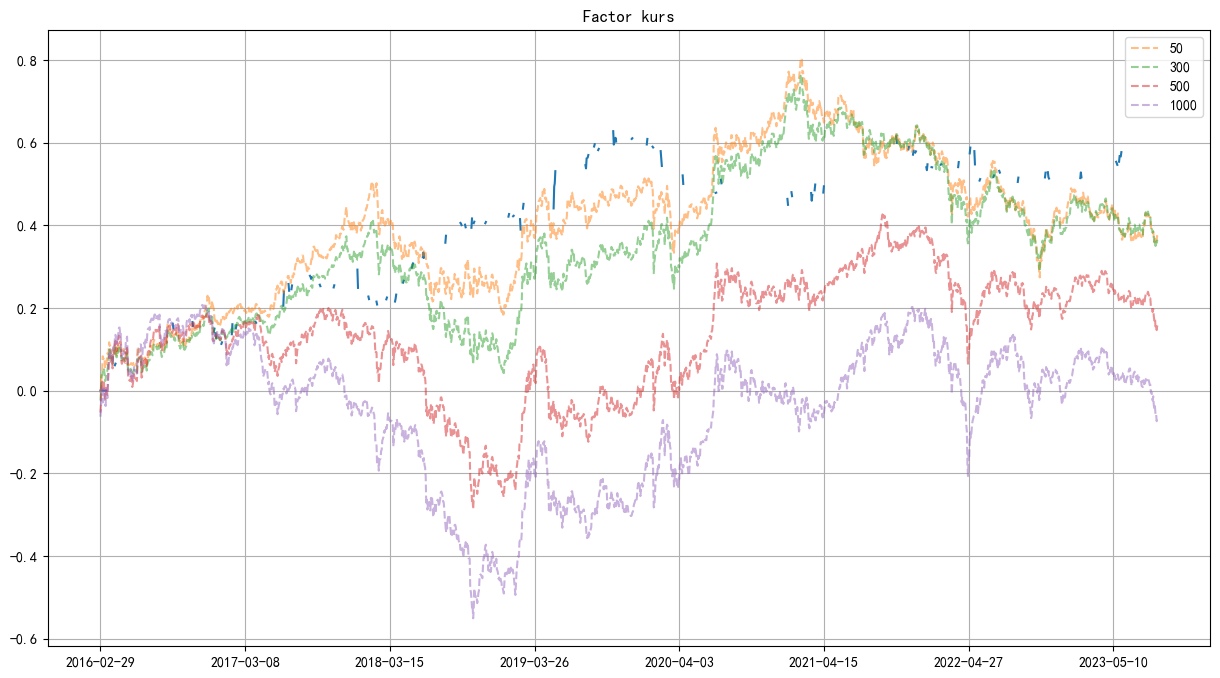

In [217]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    (idx_SR**(1/3)).rolling(1,min_periods=1).mean().dropna().T.loc[['50', '1000']],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=-1,
    fee=0.000,
    name='kurs'
)

3850.0
yoy: 0.19598474736777644 
 mdd: -0.3162555289607656 
 sharpe: 1.2976454204759837 
 rankIC: 0.03595683933868232 
 rankIR: 0.05636728570771718 
 win%: 0.5245346869712352 
 gain_loss%: -1.130176494263907


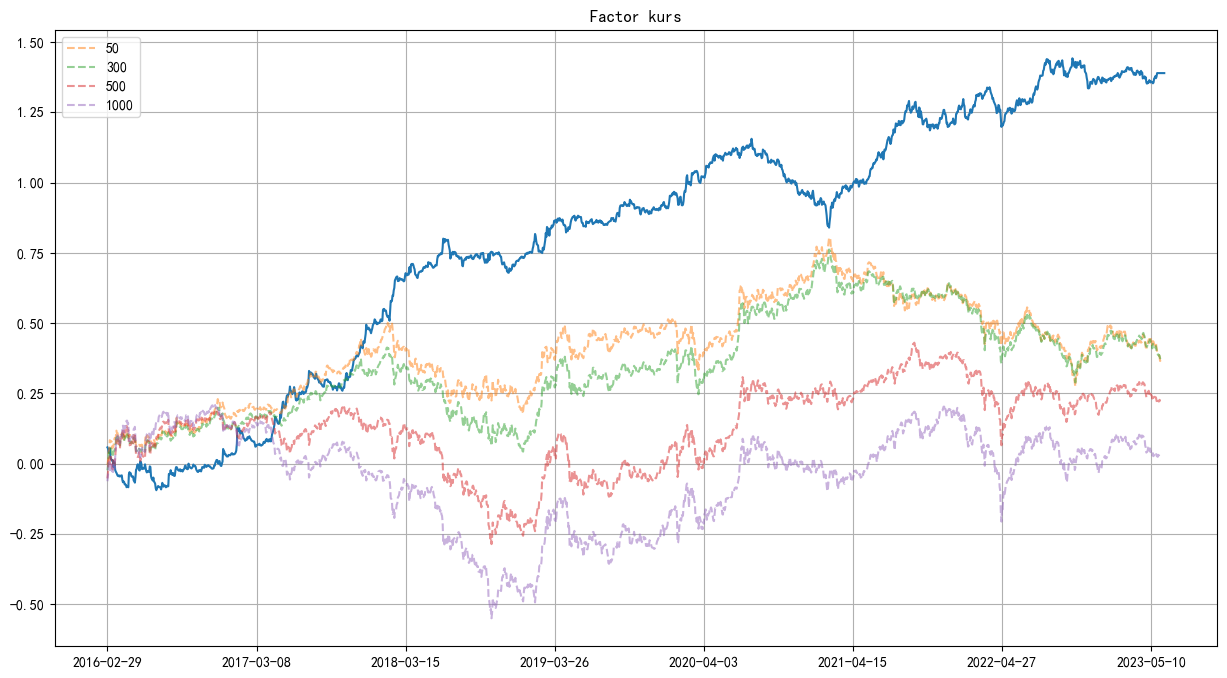

In [6]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='kurs'
)

0.02969186664045665

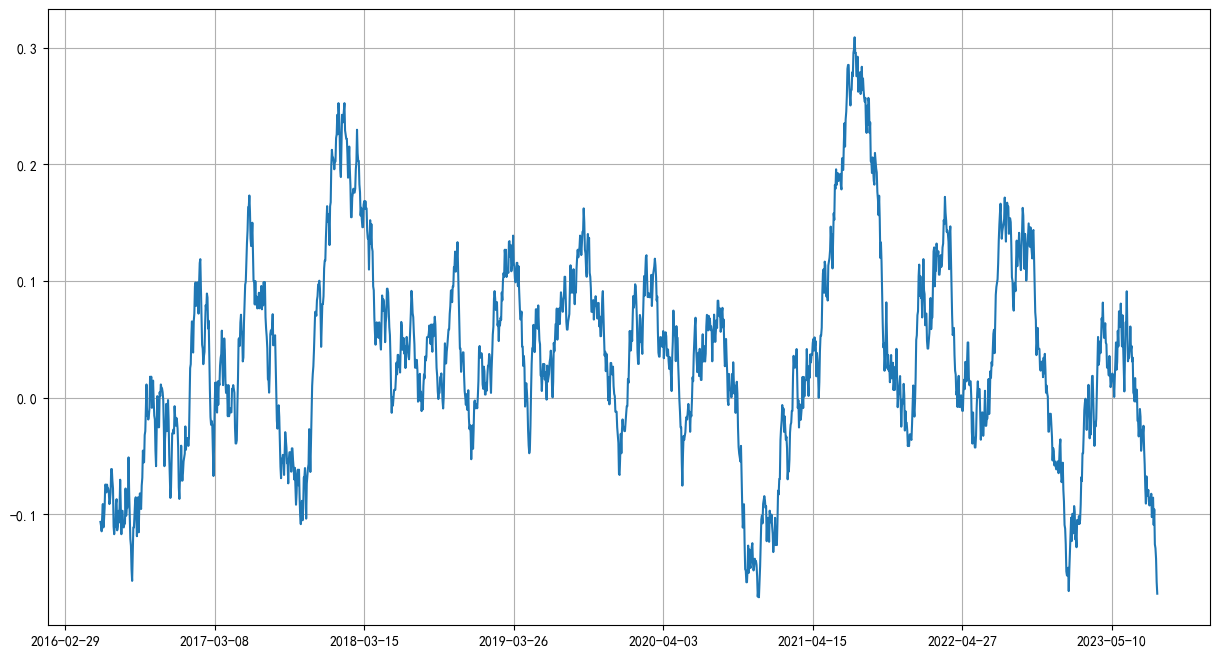

In [34]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(ETFKURScountjq_s.T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

#### 多头

In [396]:
i

160

In [122]:
std_SR = ((idx_SR - idx_SR.rolling(20,min_periods=1).mean())/idx_SR.rolling(20,min_periods=1).std()).dropna()

<Axes: >

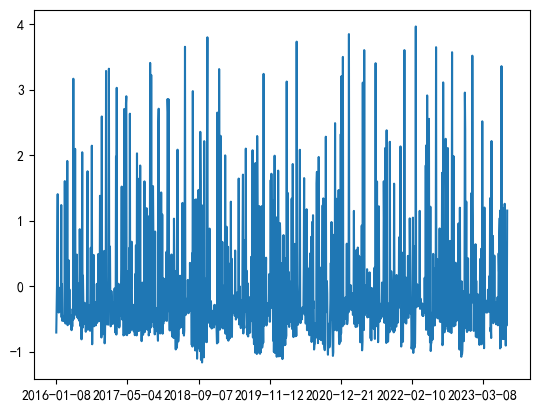

In [151]:
std_SR['1000'].plot()

In [148]:
j

1.29

In [149]:
i

1.1

shrh: -1.0 win%: 0.4567901234567901 gainloss%: -1.0086510769805688
shrh: -0.7 win%: 0.5316455696202531 gainloss%: -0.8724002474406072
shrh: -0.4 win%: 0.5066666666666667 gainloss%: -0.721140347321001
shrh: -0.1 win%: 0.5543478260869565 gainloss%: -1.0892481501800095
shrh: 0.2 win%: 0.5 gainloss%: -0.9257363002008384
shrh: 0.5 win%: 0.5675675675675675 gainloss%: -1.1293928647136713
shrh: 0.8 win%: 0.6190476190476191 gainloss%: -0.9013509964025853
shrh: 1.1 win%: 0.4090909090909091 gainloss%: -0.8474472698653865


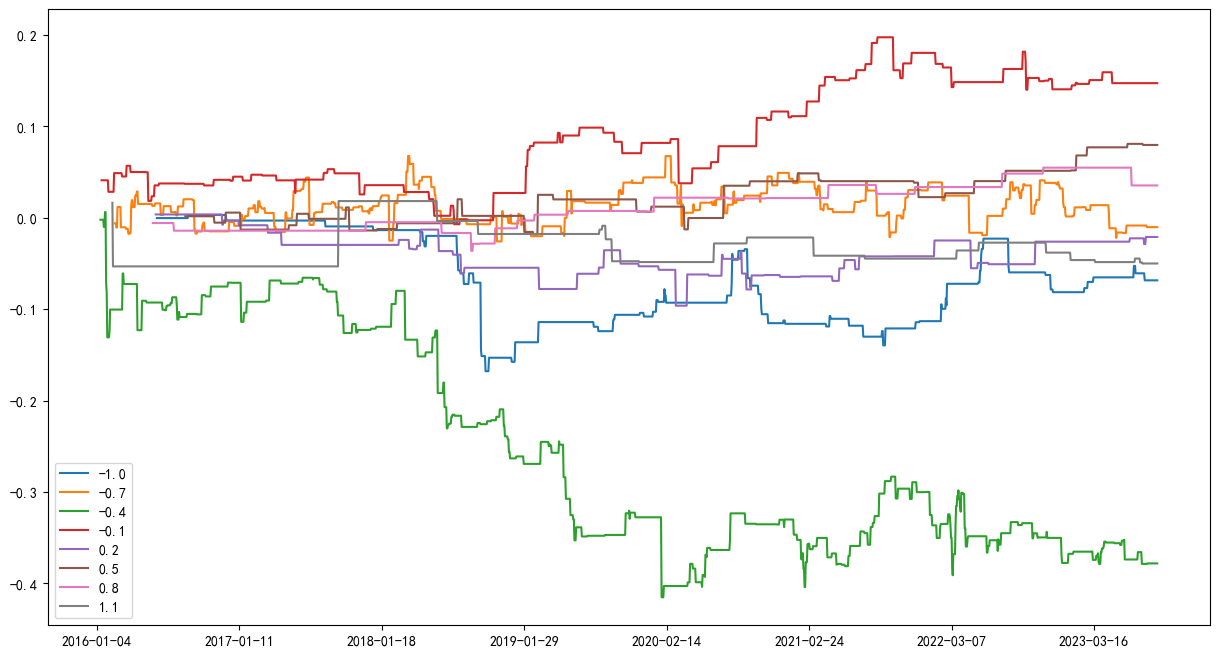

In [150]:
idx_name = '1000'
for i,j in zip(range(-100,140)[::30],range(-100,140)[19::30]):
    i = i / 100
    j = j / 100
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(std_SR[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[std_SR[idx_name][(std_SR[idx_name]>i) & (std_SR[idx_name]<j)].index&same_dt]

    
    if len(ts_ret) < 1:
        continue

    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

#### 空头

In [ ]:
idx_name = '1000'
for i in range(30)[::3]:
    # i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(ETFKURScountjq_s[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[ETFKURScountjq_s[idx_name][ETFKURScountjq_s[idx_name]<-i].index&same_dt]
    
    # if len(ts_ret) < 1:
    #     continue
        
    win_pct = ts_ret[ts_ret<0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret<0].mean()/ts_ret[ts_ret>0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

ZeroDivisionError: division by zero

### cl_op

0.12593860888230676
1 0.9966044142614601
2 0.9966044142614601
3 0.9966044142614601
4 0.9966044142614601


<Axes: >

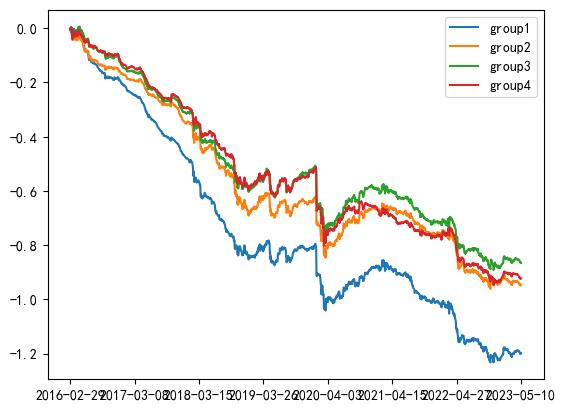

In [247]:
# 分组收益率
gr_kurs = xy.cal_rate_group(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_kurs.cumsum().plot()

3850.0
yoy: 0.037748406622726716 
 mdd: -0.1175367032696043 
 sharpe: 0.8687778129622482 
 rankIC: 0.0699718640086014 
 rankIR: 0.11269988821366834 
 win%: 0.5442752397067118 
 gain_loss%: -0.9730719222889005


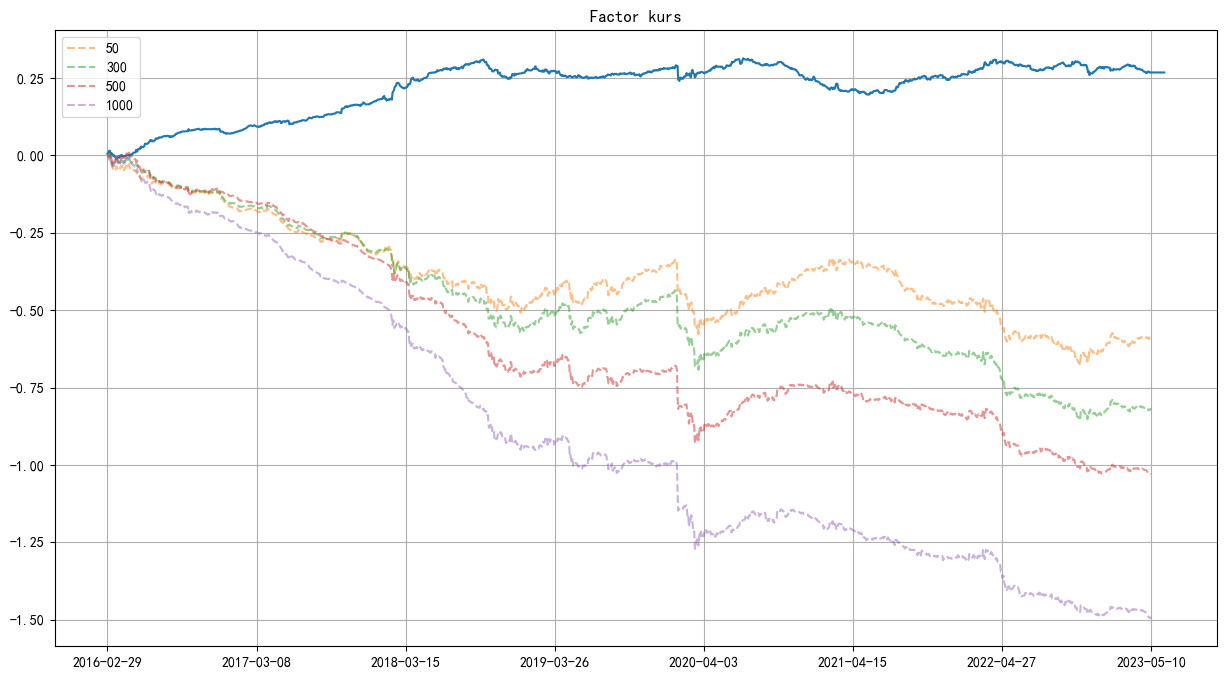

In [253]:
# 单因子强弱
KURScount_select, KURScount_rets = xy.single_Factor_backtest(
    ETFKURScountjq_s.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='kurs'
)

0.0699718640086014

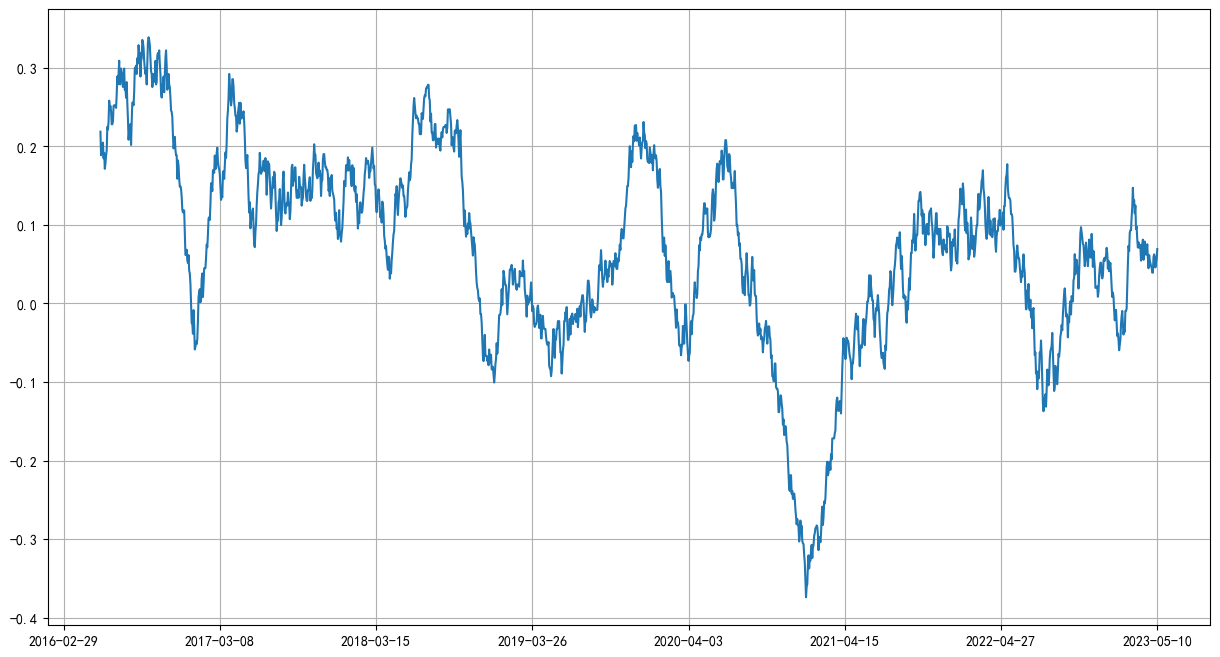

In [254]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(ETFKURScountjq_s.T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

In [152]:
idx_SR.rolling(3,min_periods=1).mean().T

,2016-01-05,2016-01-06,2016-01-08,2016-01-12,2016-01-14,2016-01-15,2016-01-18,2016-01-19,2016-01-20,2016-01-22,...,2017-09-27,2018-07-24,2019-01-21,2019-09-05,2019-11-19,2020-08-31,2021-01-12,2021-05-17,2022-07-21,2023-02-17
50,NaN,3.133531,1.723703,1.327303,0.606677,0.846788,0.925525,1.187114,0.988421,0.973818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,NaN,8.076132,4.170398,2.923311,0.445721,0.730185,0.890970,1.014775,0.646005,0.727594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,NaN,1.361351,0.686744,0.557977,0.276162,0.845834,1.199515,8.194711,7.837852,8.048347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,1.469800,0.737472,0.628624,0.349004,0.755164,1.282001,10.591181,10.365318,10.316558,...,3.200679,3.47059,0.405643,1.265754,4.908713,4.790998,5.571127,1.670766,2.40806,2.233029


In [221]:
(idx_SR**(1/3)).rolling(1,min_periods=1).mean().fillna(0).dropna().T.loc[:].to_csv('../NewFactor/idx_SR.csv')

In [228]:
(idx_SR**(1/3)).rolling(1,min_periods=1).mean().dropna()

,50,300,500,1000
2016-01-05,1.065602,1.126623,2.139975,1.763032
2016-01-08,0.000000,0.000000,0.000000,0.000000
2016-01-12,2.602660,3.405642,4.573923,4.714397
2016-01-14,1.639883,2.550442,3.855914,4.335811
2016-01-19,3.648570,3.157177,4.093824,4.550863
...,...,...,...,...
2023-07-07,1.579424,2.268247,2.861480,3.347760
2023-07-14,1.105209,1.380337,1.704257,1.736909
2023-07-21,1.974681,2.363928,1.995825,2.156587
2023-07-28,1.830151,2.235378,2.069242,1.947817
